In [128]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [129]:
#df_stage = pd.read_csv("../results/gene_exp_analysis/cnv_genes_exp_stage.combine.csv",
                 #header=0,sep="\t")
df = pd.read_csv("../results/gene_exp_analysis/lasso_selected_count.csv",
                 header=0,sep="\t")
label = pd.read_csv("../results/gene_exp_analysis/clinical.csv",
                    header=0,sep="\t")

In [130]:
label

,sample,OS,X_PATIENT,OS.time,stage
0,TCGA.2F.A9KQ.01A,0,TCGA-2F-A9KQ,2886,3
1,TCGA.2F.A9KT.01A,0,TCGA-2F-A9KT,2352,2
2,TCGA.2F.A9KW.01A,1,TCGA-2F-A9KW,254,3
3,TCGA.4Z.AA7M.01A,0,TCGA-4Z-AA7M,495,3
4,TCGA.4Z.AA7N.01A,1,TCGA-4Z-AA7N,1367,3
...,...,...,...,...,...
287,TCGA.ZF.AA51.01A,0,TCGA-ZF-AA51,1714,2
288,TCGA.ZF.AA53.01A,0,TCGA-ZF-AA53,1761,2
289,TCGA.ZF.AA58.01A,0,TCGA-ZF-AA58,1649,4
290,TCGA.ZF.AA5H.01A,0,TCGA-ZF-AA5H,897,4


In [131]:
label["OS"].value_counts()

OS
0    189
1    103
Name: count, dtype: int64

In [132]:
df

,TCGA.2F.A9KQ.01A,TCGA.2F.A9KT.01A,TCGA.2F.A9KW.01A,TCGA.4Z.AA7M.01A,TCGA.4Z.AA7N.01A,TCGA.4Z.AA7O.01A,TCGA.4Z.AA7R.01A,TCGA.4Z.AA7W.01A,TCGA.4Z.AA7Y.01A,TCGA.4Z.AA81.01A,...,TCGA.ZF.A9RM.01A,TCGA.ZF.AA4V.01A,TCGA.ZF.AA4W.01A,TCGA.ZF.AA4X.01A,TCGA.ZF.AA51.01A,TCGA.ZF.AA53.01A,TCGA.ZF.AA58.01A,TCGA.ZF.AA5H.01A,TCGA.ZF.AA5P.01A,genes
0,5425,3333,2656,8436,2546,7942,6302,1505,6467,3650,...,6645,2751,1014,17287,2241,1238,3376,2865,3383,ENSG00000000003
1,75,50,112,38,90,21,100,125,41,17,...,16,285,212,15,54,107,100,494,237,ENSG00000013619
2,4825,10042,12345,3910,1253,1652,4148,1984,4584,2699,...,10869,3480,1842,4973,4107,975,3954,4856,4887,ENSG00000025772
3,1965,1643,5597,4014,1105,1128,3006,891,2233,2269,...,4327,2061,1625,3128,1565,838,2415,2834,2208,ENSG00000030066
4,835,316,687,395,348,238,345,64,538,379,...,939,276,179,518,168,150,352,484,348,ENSG00000037749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,266,1636,118,367,635,158,220,188,402,220,...,350,415,5849,375,227,331,352,329,159,ENSG00000162757
238,1,0,1,0,3,0,158,3,3,0,...,2,36,16,10,3,5,879,3,66,ENSG00000162891
239,7916,5039,5801,5869,4086,3341,4353,2195,7053,3799,...,6881,6489,3419,5796,3528,3282,4734,5130,4124,ENSG00000162923
240,102,70,404,208,158,110,219,148,141,25,...,50,79,32,20,65,117,178,150,97,ENSG00000162946


In [133]:
genes_ensemble_id = df["genes"]
df = df.drop(["genes"],axis=1)
#genes_ensemble_id_stage = df_stage["genes"]
#df_stage = df_stage.drop(["genes"],axis=1)

In [134]:
df = df.T
#df.rename(columns=genes_ensemble_id,inplace=True)
# df_stage = df_stage.T
# df_stage.rename(columns=genes_ensemble_id_stage,inplace=True)

In [135]:
df

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
TCGA.2F.A9KQ.01A,5425,75,4825,1965,835,19651,114,1256,2643,2612,...,145,875,327,470,5826,266,1,7916,102,1797
TCGA.2F.A9KT.01A,3333,50,10042,1643,316,3856,23,1036,4801,2020,...,757,4590,69,147,8328,1636,0,5039,70,1410
TCGA.2F.A9KW.01A,2656,112,12345,5597,687,5378,90,1748,2728,2176,...,19,3107,362,1268,11725,118,1,5801,404,1837
TCGA.4Z.AA7M.01A,8436,38,3910,4014,395,3171,13,1226,3903,1193,...,577,3410,102,932,19256,367,0,5869,208,1501
TCGA.4Z.AA7N.01A,2546,90,1253,1105,348,4794,445,758,1946,567,...,167,2981,308,1674,4159,635,3,4086,158,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.ZF.AA51.01A,2241,54,4107,1565,168,4661,60,764,3225,873,...,20,2318,287,2289,6377,227,3,3528,65,1417
TCGA.ZF.AA53.01A,1238,107,975,838,150,3717,1013,861,1486,914,...,2388,11756,6826,1197,9241,331,5,3282,117,1675
TCGA.ZF.AA58.01A,3376,100,3954,2415,352,7459,342,1701,1802,2442,...,2749,9230,334,21491,15169,352,879,4734,178,2494
TCGA.ZF.AA5H.01A,2865,494,4856,2834,484,9794,1077,1810,8589,2843,...,195,5358,478,13507,24957,329,3,5130,150,2258


In [136]:
label= label.set_index('sample')

In [137]:
label

,OS,X_PATIENT,OS.time,stage
sample,,,,
TCGA.2F.A9KQ.01A,0,TCGA-2F-A9KQ,2886,3
TCGA.2F.A9KT.01A,0,TCGA-2F-A9KT,2352,2
TCGA.2F.A9KW.01A,1,TCGA-2F-A9KW,254,3
TCGA.4Z.AA7M.01A,0,TCGA-4Z-AA7M,495,3
TCGA.4Z.AA7N.01A,1,TCGA-4Z-AA7N,1367,3
...,...,...,...,...
TCGA.ZF.AA51.01A,0,TCGA-ZF-AA51,1714,2
TCGA.ZF.AA53.01A,0,TCGA-ZF-AA53,1761,2
TCGA.ZF.AA58.01A,0,TCGA-ZF-AA58,1649,4


In [138]:
death_label=np.array([])
for sample in df.index:
    death_label = np.append(death_label,label.loc[sample]["OS"])

In [139]:
death_label

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 1.

In [176]:
scaled_df = scaler.fit_transform(df)
X = scaled_df
y = death_label
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7)


In [179]:
from sklearn.manifold import TSNE
import plotly.express as px


features = X

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

fig = px.scatter(
    projections, x=0, y=1,
    color=y
)
fig.show()

In [180]:
from umap import UMAP
import plotly.express as px

umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=y
)

fig_2d.show()


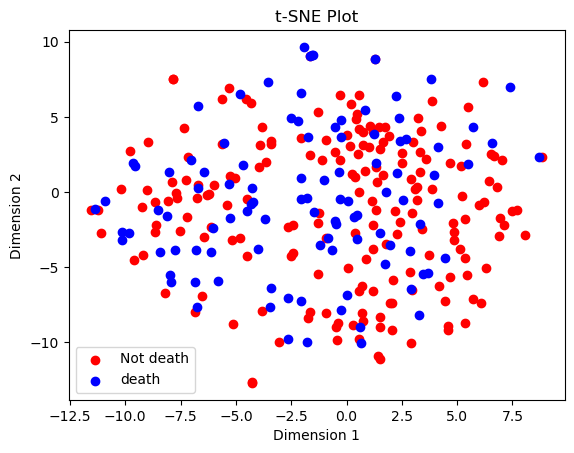

In [181]:
from sklearn.manifold import TSNE
# Assuming your data is stored in the variable 'data'
tsne = TSNE(n_components=2)
embedded_data = tsne.fit_transform(X)

# Step 2: Separate data points by class
class_1_indices = np.where(y == 0)[0]
class_2_indices = np.where(y == 1)[0]

class_1_data = embedded_data[class_1_indices]
class_2_data = embedded_data[class_2_indices]

# Step 3: Plot the t-SNE plot with different colors for each class
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], color='red', label='Not death')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], color='blue', label='death')

plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model=RandomForestClassifier(random_state=42)

# defining parameter range
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,12,14,16,20],
    'criterion' :['gini', 'entropy']
}

In [183]:
# from sklearn.linear_model import RidgeClassifier
# model=RidgeClassifier()
# param_grid = {'alpha':[0.001,0.01,0.1,1 ]}

In [192]:
# model = xgb.XGBClassifier(random_state=42)

# # Defining parameter range
# param_grid = {
#     'max_depth': [3],
#     'learning_rate': [0.1 ,0.01, 0.001],
#     'n_estimators': [100],
#     'gamma': [ 0.1,0.01,0.001],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [ 0.5, 0.8]
# }

In [196]:
grid = GridSearchCV(model, param_grid, refit = True, verbose = 1)
  
# fitting the model for grid search
grid.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77        78
         1.0       0.54      0.51      0.53        39

    accuracy                           0.69       117
   macro avg       0.65      0.65      0.65       117
weighted avg       0.69      0.69      0.69       117



In [186]:
def roc(X_train,y_train,model,label):
    cv = StratifiedKFold(n_splits=6)
    classifier = model
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
        classifier.fit(X_train.iloc[train], y_train[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_train.iloc[test],
            y_train[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=label,
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()


In [187]:
model

RandomForestClassifier(random_state=42)

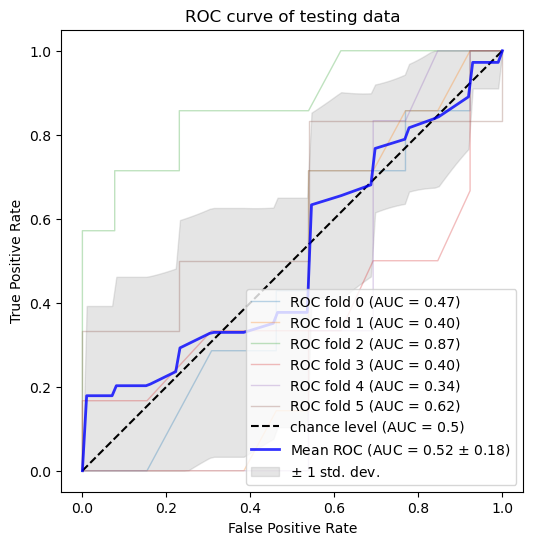

In [188]:
model = grid.best_estimator_
label="ROC curve of testing data"
X_test = pd.DataFrame(X_test)
roc(X_test,y_test,model,label)

In [189]:
model_RF = grid.best_estimator_
model_RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features='auto', random_state=42)

In [190]:
# for important features:
important_feat = model_RF.feature_importances_
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:18]

In [191]:
genes_ensemble_id[idx]

83     ENSG00000124831
166    ENSG00000143772
76     ENSG00000123610
67     ENSG00000118729
157    ENSG00000141873
58     ENSG00000115266
167    ENSG00000143951
165    ENSG00000143409
121    ENSG00000135144
215    ENSG00000157869
22     ENSG00000078795
176    ENSG00000146085
88     ENSG00000126432
6      ENSG00000048052
4      ENSG00000037749
149    ENSG00000139323
162    ENSG00000143067
214    ENSG00000157637
Name: genes, dtype: object

ENSG00000184697
ENSG00000237412
ENSG00000265787
ENSG00000277586